### This is my attempt at the Relax Inc. Take-Home Challenge. First, let's load the data and check if it is properly cleaned.

In [39]:
import pandas as pd
import numpy as np

import csv  

#For all data - train = pd.read_csv("/root/Springboard/Data/cleaning/allArticles.csv")
user_engagement = pd.read_csv("data/takehome_user_engagement.csv")

In [2]:
user_engagement.head(5)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
user_engagement.isnull().values.any()

False

In [40]:
users = pd.read_csv("data/takehome_users.csv", encoding='latin-1')

In [5]:
users.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
users.isnull().values.any()

True

##### The users data file has some null values. Let's find and clean them.

In [7]:
users.isnull().any()

object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time     True
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
dtype: bool

In [8]:
nan_rows = users[users['last_session_creation_time'].isnull()]
nan_rows

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN
11,12,2014-04-17 23:48:38,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaN,0,0,130,9270.0
14,15,2013-07-16 21:33:54,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,175,NaN
15,16,2013-02-11 10:09:50,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,211,NaN
17,18,2013-08-24 00:26:46,Gregersen Celina,CelinaAGregersen@jourrapide.com,GUEST_INVITE,NaN,0,0,2,3153.0
25,26,2013-07-28 00:53:32,Wexler Florian,FlorianWexler@jourrapide.com,ORG_INVITE,NaN,0,0,56,11857.0
31,32,2013-04-17 16:21:30,Perez Timothy,TimothyJPerez@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,98,NaN
33,34,2014-02-03 20:55:18,Holm Sara,SaraMHolm@hotmail.com,ORG_INVITE,NaN,0,0,33,3721.0
34,35,2013-08-01 10:55:26,Krueger Dieter,DieterKrueger@gustr.com,PERSONAL_PROJECTS,NaN,0,0,59,NaN


### It looks like some users have a 'last session creation time' of NaN. I'll set that to '0' as a placeholder. We also see users who were not invited by anyone else to have NaN for 'invited by user id' which I will also set to 0.

In [9]:
users.fillna(0, inplace=True)
users.isnull().any()

object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time    False
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id            False
dtype: bool

### Step 1: Using the data in the 'takehome_user_engagement' file, identify each user in the 'takehome_users' file as either adopted or nonadopted. The 'user_id' and 'object_id' cells both refer to the user id. Create a column for 'users' which is set to 1 if their id is present 3 or more times in a one-week period, and 0 otherwise.

In [10]:
users['is_engaged'] = -1

In [12]:
from datetime import date

#Function to see how long between logins

def diff_dates(date1, date2):
    return (date2-date1).days

#Check each user ID and check login timestamps to see if the user counts as 'engaged'. Save the result to the users df.

def is_registered(users, user_engagement):
    
    for index, row in users.iterrows():
        is_engaged_flag = 0
        MemID = row['object_id']
        #if (MemID > 200): break

        #Get the slice of the engagement df relevant to this user, then loop through all logins
        
        engagementSlice = user_engagement.loc[user_engagement['user_id'] == MemID]
        engagementSlice.sort_values(by=['time_stamp'])
        
        for index, row in engagementSlice.iterrows():
            currDate = pd.to_datetime(row['time_stamp'])
            weekly_logins = 1
            
            for index, row in engagementSlice.iterrows():
                compareDate = pd.to_datetime(row['time_stamp'])
                if (compareDate == currDate): continue
                
                if (row['user_id'] == MemID and diff_dates(compareDate, currDate) >= 1 
                    and diff_dates(compareDate, currDate) <= 7): 
                
                    weekly_logins = weekly_logins + 1
                    #print("Considering User # " + str(MemID) + " With weekly logins at " + str(weekly_logins) + " and compare date is " + str(compareDate) + ", currDate is " + str(currDate))
                if (weekly_logins == 3):
                
                    is_engaged_flag = 1
                    break
                
            if (is_engaged_flag == 1): break
        
        #save the result for this user
        
        if (is_engaged_flag == 1):
            users.loc[MemID-1, 'is_engaged'] = 1
            #print("Considering User # " + str(MemID) + " as " + str(is_engaged_flag))
        else:
            users.loc[MemID-1, 'is_engaged'] = 0
            #print("Considering User # " + str(MemID) + " as " + str(is_engaged_flag))
       

In [13]:
### this takes awhile to run (~3 minutes). For a larger dataset, it would need to be optimized (parallelizable SQL query?), but it works fine here.

is_registered(users, user_engagement)

In [14]:
users.head(50)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_engaged
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,0.0,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,0.000000e+00,1,1,74,0.0,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,0.000000e+00,0,0,302,0.0,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1


In [38]:
active_file_name = "data/userdata_with_active_label.csv"
users.to_csv(active_file_name, encoding='utf-8', index=False)

### I have now saved my modified user data. I can start from here from now on.

In [41]:
import pandas as pd
import numpy as np

import csv  

user_engagement_modified = pd.read_csv("data/userdata_with_active_label.csv")

In [17]:
user_engagement_modified.head(50)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_engaged
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,0.0,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,0.000000e+00,1,1,74,0.0,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,0.000000e+00,0,0,302,0.0,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1


### First let's look at correlation coefficients. Are any variables highly correlated?

In [18]:
# Encode the variables as labels

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
user_engagement_modified_trans = user_engagement_modified.apply(le.fit_transform)
user_engagement_modified_trans.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_engaged
0,0,10807,2087,1047,0,6562,1,0,11,2325,0
1,1,7647,8488,7290,1,6212,0,0,1,56,1
2,2,3939,1259,7681,1,2254,0,0,94,298,0
3,3,4845,2099,7971,0,2851,0,0,1,1104,0
4,4,3018,8708,3718,0,1746,0,0,193,1127,0


In [19]:
user_engagement_modified_trans[user_engagement_modified_trans.columns[1:]].corr()['is_engaged'][:]

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

#Using Pearson Correlation

plt.figure(figsize=(60,50))
fig, ax = plt.subplots()

cor = user_engagement_modified_trans.corr()
features = user_engagement_modified.columns.tolist()

ax.set_xticks(np.arange(len(features)))
ax.set_yticks(np.arange(len(features)))

ax.set_xticklabels(features)
ax.set_yticklabels(features)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)


plt.imshow(cor, cmap='YlGn', interpolation='nearest')
#plt.show()

# Loop over data dimensions and create text annotations.
for i in range(len(features)):
    for j in range(len(features)):
        text = ax.text(j, i, round(cor.iloc[i][j], 2))

#fig.tight_layout()
plt.show()

<Figure size 6000x5000 with 0 Axes>

<Figure size 1850x1050 with 1 Axes>

##### last_session_creation_time is highly correlated with is_engaged and creation_time. These seem intuitively reasonable. invited_by_user_id is anticorrelated with creation_source, perhaps because organizational users don't name a specific inviter?

##### There is no reason to expect the user ID, name or email fields to predict user engagement directly. Let's remove these fields, then train a random forest model on our data. The most significant features of this model should have the highest predictive power.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

features = user_engagement_modified.columns.tolist()
output = 'is_engaged'
features.remove(output)

features.remove('object_id')
features.remove('name') 
features.remove('email')

X = user_engagement_modified_trans[features].astype('category')
y = user_engagement_modified_trans[output]

In [21]:
rf = RandomForestClassifier()

param = {'n_estimators': [5, 10, 20, 50],
         'max_depth': [5, 10, 20, 50] }

gs=GridSearchCV(rf, param, cv=5, n_jobs=5)

gs_fit = gs.fit(X, y)

pd.DataFrame(gs_fit.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.289399,0.003879,0.014201,0.000749,20,50,"{'max_depth': 20, 'n_estimators': 50}",0.966264,0.960833,0.963333,0.966250,0.965819,0.964500,0.002132,1
15,0.283800,0.006584,0.014800,0.000981,50,50,"{'max_depth': 50, 'n_estimators': 50}",0.964598,0.961250,0.964167,0.966250,0.964985,0.964250,0.001653,2
10,0.119998,0.003098,0.007200,0.000401,20,20,"{'max_depth': 20, 'n_estimators': 20}",0.966681,0.961250,0.962500,0.966667,0.962484,0.963917,0.002297,3
14,0.119800,0.002561,0.007400,0.000490,50,20,"{'max_depth': 50, 'n_estimators': 20}",0.963765,0.961250,0.960000,0.966250,0.962484,0.962750,0.002152,4
13,0.064199,0.002136,0.004800,0.000400,50,10,"{'max_depth': 50, 'n_estimators': 10}",0.961683,0.960000,0.962500,0.965417,0.961234,0.962167,0.001815,5


### Our accuract of ~96% seems quite reasonable - our model's feature rankings should tell us a lot about this data.

Feature ranking:
1. feature 2 : (creation_time) (0.679218)
2. feature 0 : (creation_source) (0.214344)
3. feature 5 : (last_session_creation_time) (0.054062)
4. feature 6 : (opted_in_to_mailing_list) (0.034494)
5. feature 1 : (enabled_for_marketing_drip) (0.010459)
6. feature 3 : (org_id) (0.004017)
7. feature 4 : (invited_by_user_id) (0.003406)


<Figure size 432x288 with 0 Axes>

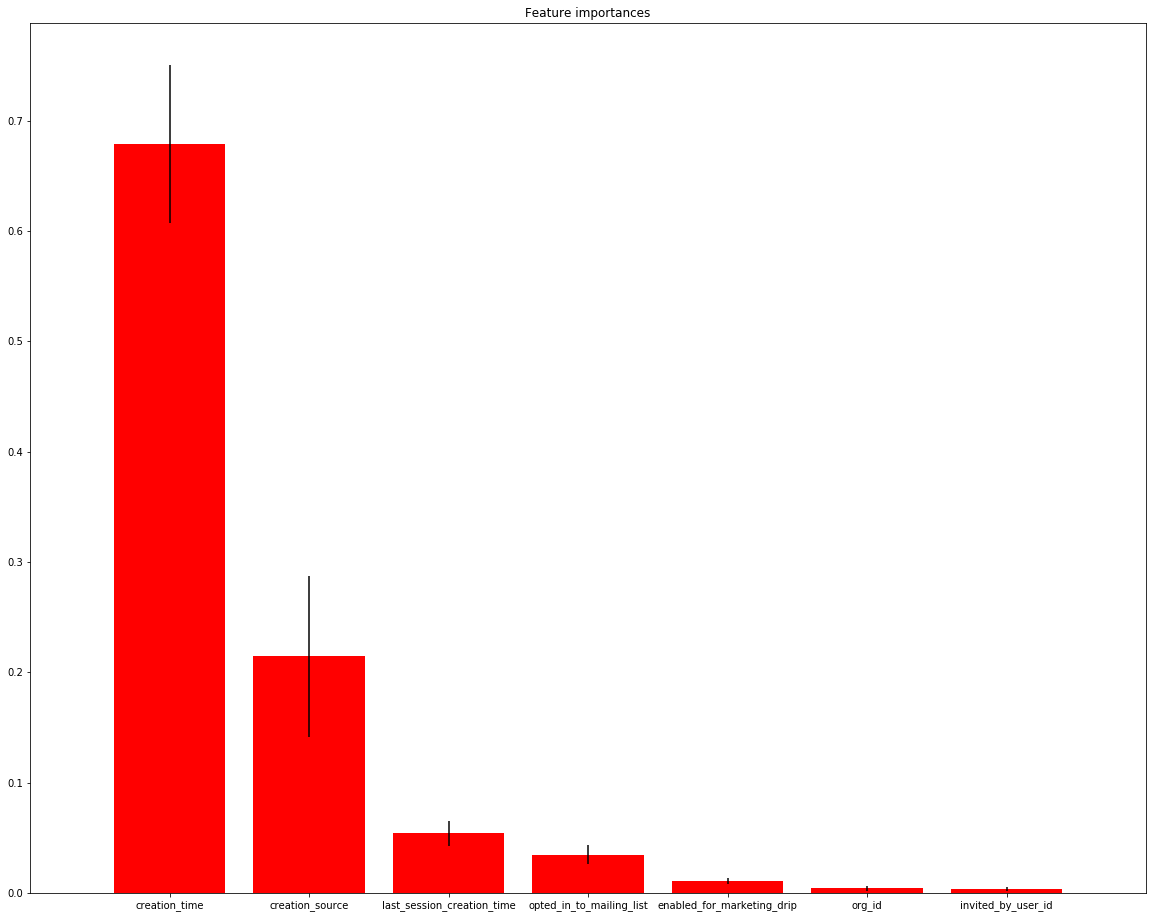

<Figure size 432x288 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt

importances = gs_fit.best_estimator_.feature_importances_

std = np.std([tree.feature_importances_ for tree in gs_fit.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")


for f in range(user_engagement_modified[features].shape[1]):
    print("%d. feature %d : (%s) (%f)" % (f + 1, indices[f], features[f], importances[indices[f]]))
    
    # Plot the feature importances of the forest
plt.figure()
plt.figure(figsize=(20,16))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.title("Feature importances")
plt.bar(range(user_engagement_modified[features].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(user_engagement_modified[features].shape[1]), features)
plt.xlim([-1, user_engagement_modified[features].shape[1]])
plt.show()

plt.savefig('graphs/Feature importances_of_Random_Forest.png')

### Here we see that the two most important features are the creation time (When the account was created) and the creation source (how the account was created).

In [23]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4),  gs_fit.best_estimator_.feature_importances_), features), 
             reverse=True))

Features sorted by their score:
[(0.6792, 'last_session_creation_time'), (0.2143, 'creation_time'), (0.0541, 'org_id'), (0.0345, 'invited_by_user_id'), (0.0105, 'creation_source'), (0.004, 'opted_in_to_mailing_list'), (0.0034, 'enabled_for_marketing_drip')]


In [24]:
engagedSlice = user_engagement_modified.loc[user_engagement_modified['is_engaged'] == 1]
unengagedSlice = user_engagement_modified.loc[user_engagement_modified['is_engaged'] == 0]

In [25]:
print(len(engagedSlice))
print(len(unengagedSlice))
print(len(engagedSlice) / len(unengagedSlice))

1656
10344
0.16009280742459397


In [26]:
engagedSlice['creation_source'].value_counts(normalize=True)


ORG_INVITE            0.346618
GUEST_INVITE          0.222826
SIGNUP                0.182367
SIGNUP_GOOGLE_AUTH    0.144324
PERSONAL_PROJECTS     0.103865
Name: creation_source, dtype: float64

In [27]:
unengagedSlice['creation_source'].value_counts(normalize=True)

ORG_INVITE            0.355762
PERSONAL_PROJECTS     0.187452
GUEST_INVITE          0.173434
SIGNUP                0.172564
SIGNUP_GOOGLE_AUTH    0.110789
Name: creation_source, dtype: float64

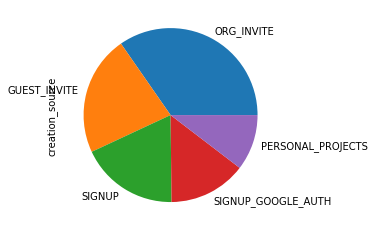

In [51]:
engagedSlice['creation_source'].value_counts(normalize=True).plot(kind='pie')

plt.savefig('graphs/engaged_user_source.png')

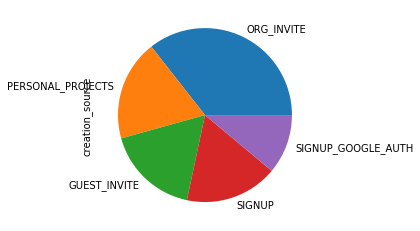

In [49]:
#import matplotlib.pyplot.savefig

fig = unengagedSlice['creation_source'].value_counts(normalize=True).plot(kind='pie')

fig

plt.savefig('graphs/unengaged_user_source.png')

##### We do see some differences in the creation source between engaged and unengaged users - in particular, users making personal projects were proportionally much less likely to be engaged.

In [30]:
user_engagement_modified

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_engaged
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,0.0,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,0.000000e+00,1,1,74,0.0,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,0.000000e+00,0,0,302,0.0,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1


In [31]:
user_engagement_modified.sort_values(by=['creation_time'])
#user_engagement_modified['is_engaged'].value_counts(normalize=True)

#print(user_engagement_modified[0:6000]['is_engaged'].value_counts(normalize=True))
#print(user_engagement_modified[6001:12000]['is_engaged'].value_counts(normalize=True))

timeSeries = pd.DataFrame(columns = ['elemNo', 'engaged', 'unengaged'])

unengagedCounts = 0
engagedCounts = 0

size = 500

for index, row in user_engagement_modified.iterrows():

    if (row['is_engaged'] == 0): unengagedCounts += 1
    else: engagedCounts+= 1       
    
    if ((index+1) % size == 0): 
        elemNo = int(((index+1)/size)-1)
        #print(elemNo, unengagedCounts, engagedCounts)
        timeSeries.loc[elemNo, 'elemNo'] = elemNo
        timeSeries.loc[elemNo, 'unengaged'] = unengagedCounts / size
        timeSeries.loc[elemNo, 'engaged'] = engagedCounts / size
        #print(timeSeries.loc[elemNo, 'engaged'], timeSeries.loc[elemNo, 'unengaged'])
        unengagedCounts = 0
        engagedCounts = 0

In [32]:
timeSeries.head(5)

,elemNo,engaged,unengaged
0,0,0.148,0.852
1,1,0.114,0.886
2,2,0.144,0.856
3,3,0.12,0.88
4,4,0.13,0.87


##### Here we have sorted users by their signup date, so group 0 is our first 500 users, group 1 is our second 500 users, and so on. We are looking for any trend line in engaged users over time. 

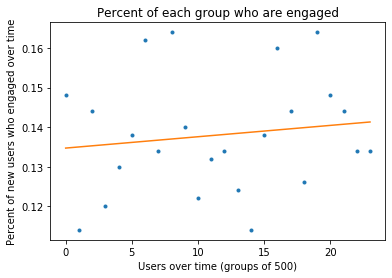

<Figure size 432x288 with 0 Axes>

In [43]:
# Plot
from numpy.polynomial.polynomial import polyfit

x = timeSeries['elemNo'].astype('float')
y = timeSeries['engaged'].astype('float')

plt.title('Percent of each group who are engaged')
plt.xlabel('Users over time (groups of 500)')
plt.ylabel('Percent of new users who engaged over time')

b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()


plt.savefig('graphs/engage_pct_over_time.png')

##### There is a small upward trend in engagement in new users over time.